### Feature Extraction Using Librosa Dataset

In [1]:
import librosa
import numpy as np
import pandas as pd
import torchaudio

# Function to extract features
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=16000)
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
    return np.hstack([mfccs, chroma, zcr, spectral_contrast])

# Load a sample audio file from LibriSpeech
datasets = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

key = 0
features = []
file_path = "librispeech_sample.wav"
for dataset in datasets:  
    # Access the first audio sample in the dataset
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset
    
    # Save the audio to a WAV file
    torchaudio.save(file_path, waveform, sample_rate)
    key += 1

    feature = extract_features(file_path)
    features.append(feature) 

# Convert the feature list to a numpy array for further processing
features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")

# Convert np array into data freame 
features_df = pd.DataFrame(features_array)
features_df.to_csv("features.csv", index=False)

Extracted features shape: (2620, 33)


In [6]:
import librosa
import numpy as np
import torchaudio
import pandas as pd

# Function to extract features from audio waveform
def extract_features_from_waveform(waveform, sample_rate):
    audio = waveform.numpy().flatten()  # Convert PyTorch tensor to numpy array
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
    return np.hstack([mfccs, chroma, zcr, spectral_contrast])

# Load a sample audio dataset from LibriSpeech
datasets = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

# Extract features from first 10 utterances
features = []
key = 0
for dataset in datasets:
    # Access audio sample and its metadata
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset
    
    # Extract features directly from waveform
    feature = extract_features_from_waveform(waveform, sample_rate)
    features.append(feature)  # Append feature array for each utterance  

# Convert the feature list to a numpy array for further processing
features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")

# Convert np array into data freame 
features_df = pd.DataFrame(features_array)
features_df.to_csv("features.csv", index=False)


Extracted features shape: (2620, 33)


In [3]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-300.538055,102.676567,-11.533751,34.515648,3.697970,3.740451,-7.779979,-5.030833,-1.161886,-0.948949,...,0.428673,0.454517,0.127497,19.646138,14.211446,16.890984,15.460212,17.686253,19.864507,14.851772
1,-364.247498,91.377350,4.104960,40.972740,3.855652,11.061490,-3.984364,-0.601738,4.034190,-2.416186,...,0.511107,0.555132,0.107820,18.037720,13.369277,16.100759,14.565921,16.484215,19.391356,14.970760
2,-303.546387,130.277008,-17.590935,26.203365,-7.220541,2.721291,-7.697184,-8.856187,1.239684,-1.230602,...,0.466134,0.469798,0.087339,21.492927,15.680788,17.941670,17.006381,17.779363,20.308019,14.854105
3,-313.242920,110.683128,-20.646511,21.182190,-5.369611,-9.688619,-9.589869,-7.087545,-10.202554,-2.014711,...,0.426402,0.498014,0.065348,21.618438,17.300488,20.150371,17.723875,18.778041,19.734620,16.104894
4,-298.868347,104.327721,-21.300791,29.336489,2.966362,-3.672034,-11.293174,-2.402841,-1.284240,0.897291,...,0.480502,0.447972,0.096332,20.960629,16.082848,17.179983,16.033419,19.139572,19.313629,15.433236


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Display the corrected dataset structure and its first few rows
features_df.info()

# Example: Assuming 'data' is your DataFrame
# Check data types
print("Data Types:")
print(features_df.dtypes)

# Drop non-numerical columns
numerical_data = features_df.select_dtypes(include=['float64', 'int64'])

# If strings are present in numerical columns, attempt conversion
for column in numerical_data.columns:
    numerical_data[column] = pd.to_numeric(numerical_data[column], errors='coerce')

# Drop rows/columns with missing values after conversion
numerical_data = numerical_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 34 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        2620 non-null   float64
 1   1        2620 non-null   float64
 2   2        2620 non-null   float64
 3   3        2620 non-null   float64
 4   4        2620 non-null   float64
 5   5        2620 non-null   float64
 6   6        2620 non-null   float64
 7   7        2620 non-null   float64
 8   8        2620 non-null   float64
 9   9        2620 non-null   float64
 10  10       2620 non-null   float64
 11  11       2620 non-null   float64
 12  12       2620 non-null   float64
 13  13       2620 non-null   float64
 14  14       2620 non-null   float64
 15  15       2620 non-null   float64
 16  16       2620 non-null   float64
 17  17       2620 non-null   float64
 18  18       2620 non-null   float64
 19  19       2620 non-null   float64
 20  20       2620 non-null   float64
 21  21       2620 

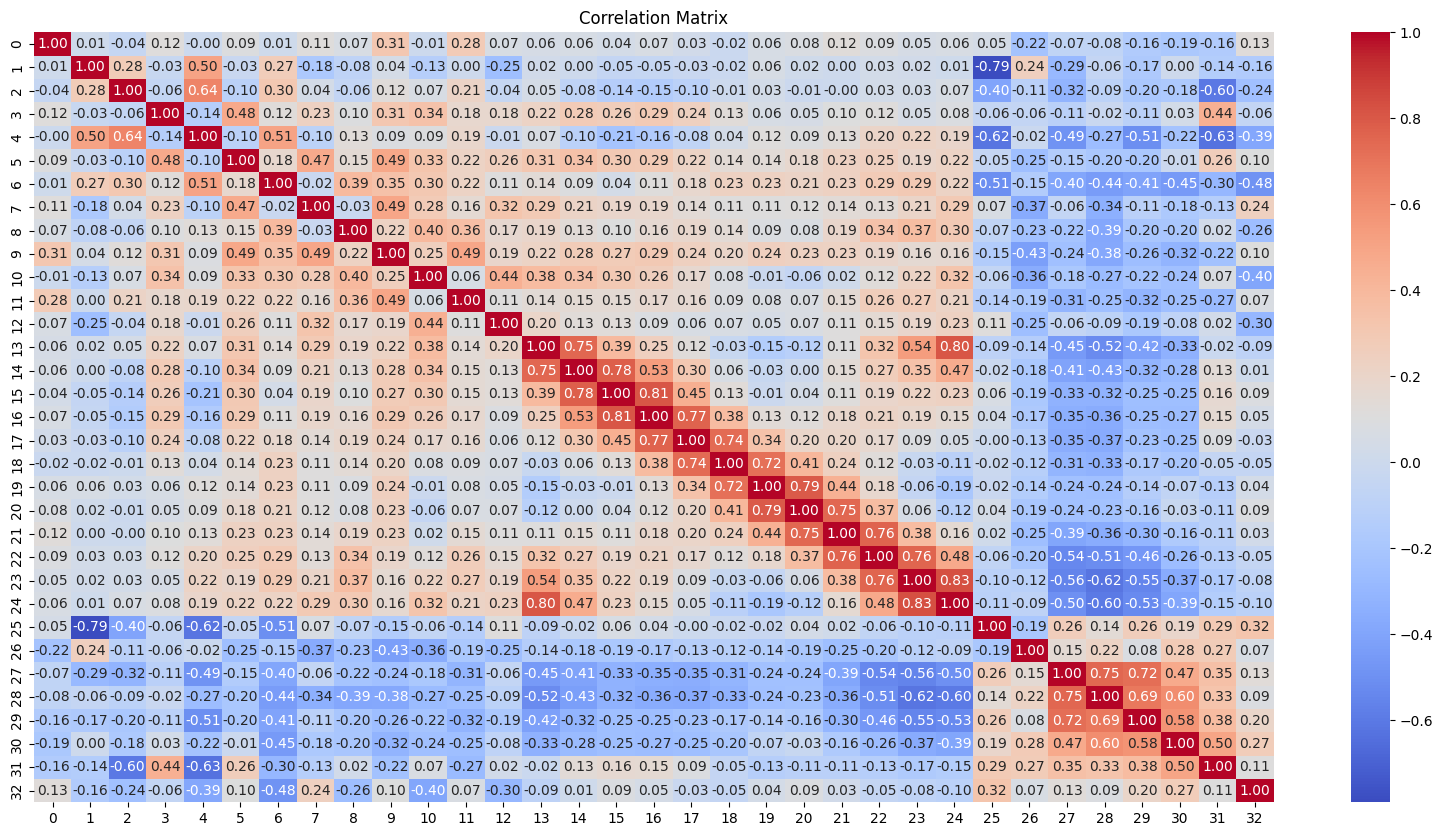

Highly Correlated Features:
    0   1   2   3   4   5   6   7   8   9   ...        23        24  25  26  \
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN  0.804801 NaN NaN   
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN NaN NaN   
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN       NaN NaN NaN   
23 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...       NaN  0.829532 NaN NaN   
24 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  0.829532       NaN NaN NaN   

    27  28  29  30  31  32  
13 NaN NaN NaN NaN NaN NaN  
15 NaN NaN NaN NaN NaN NaN  
16 NaN NaN NaN NaN NaN NaN  
23 NaN NaN NaN NaN NaN NaN  
24 NaN NaN NaN NaN NaN NaN  

[5 rows x 33 columns]


In [28]:
# Step 1: Compute the Correlation Matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Identify highly correlated features
threshold = 0.8
high_correlation = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)]
print("Highly Correlated Features:")
print(high_correlation.dropna(how='all'))


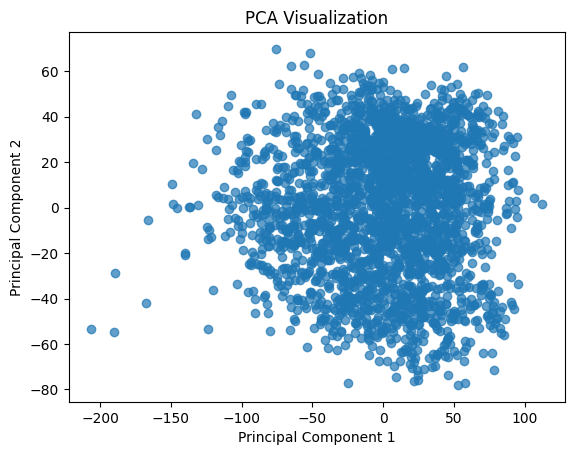

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(numerical_data)

# Scatter plot for 2D PCA
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


Silhouette Score: 0.20


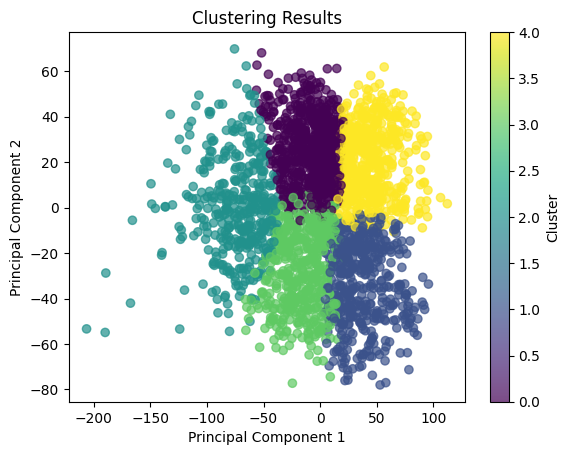

Cluster Centroids:
           0          1          2          3          4         5   \
0 -307.682365  95.535867   8.074007  25.353346   4.263155 -0.173939   
1 -262.261662  46.094740 -13.553970  24.481230 -16.202163 -0.332030   
2 -373.467355  75.586859  -2.487982  18.025590  -6.274863 -7.030420   
3 -316.522133  57.631240 -20.683380  26.238427 -18.551079  0.784776   
4 -256.306966  94.682871  -0.077419  28.027017   0.796720  0.261147   

          6         7         8         9   ...        23        24        25  \
0  -7.070105 -6.645145 -2.494365 -2.684481  ...  0.416464  0.404255  0.113902   
1 -14.469796 -3.079875 -1.852425 -1.230082  ...  0.423412  0.406760  0.203713   
2 -11.356114 -7.964624 -3.933399 -7.112493  ...  0.417806  0.399986  0.146848   
3 -12.705367 -4.695666 -2.366958 -4.494189  ...  0.413246  0.399882  0.174979   
4  -5.159158 -4.969667 -1.634730 -0.467164  ...  0.442648  0.434994  0.113935   

          26         27         28         29         30         31

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
labels = kmeans.fit_predict(numerical_data)

# Evaluate clustering using silhouette score
score = silhouette_score(numerical_data, labels)
print(f"Silhouette Score: {score:.2f}")

# Add labels to the original dataset
features_df['Cluster'] = labels

# Visualize the clusters (using PCA-reduced data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("Clustering Results")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=numerical_data.columns)
print("Cluster Centroids:")
print(centroids)



In [31]:
# Step 2: Determine Feature Importance
# Separate features and target
X = features_df.drop(columns=['Cluster'])
y = features_df['Cluster']

# Fit a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Step 3: Use Mutual Information for Feature Relevance
mutual_info = mutual_info_classif(X, y, random_state=42)
mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Information', ascending=False)

print("Feature Relevance (Mutual Information):")
print(mutual_info_df)

# Step 4: Drop Unnecessary Features
# Keep features with high importance or low correlation redundancy
important_features = feature_importance[feature_importance['Importance'] > 0.01]['Feature']
selected_features = [feature for feature in important_features if feature not in high_correlation.columns]
print("Final Selected Features:")
print(selected_features)

Feature Importance (Random Forest):
   Feature  Importance
0        0    0.340288
1        1    0.097788
25      25    0.072488
2        2    0.054205
4        4    0.053887
6        6    0.023416
31      31    0.021854
26      26    0.021589
11      11    0.017523
5        5    0.017489
32      32    0.017372
12      12    0.017306
9        9    0.015808
27      27    0.015266
3        3    0.015063
30      30    0.014783
29      29    0.014111
7        7    0.013911
10      10    0.012866
16      16    0.012533
28      28    0.012247
8        8    0.010946
15      15    0.010748
22      22    0.010687
24      24    0.010185
13      13    0.010018
21      21    0.009993
14      14    0.009541
20      20    0.009489
19      19    0.009386
17      17    0.009229
23      23    0.009104
18      18    0.008879
Feature Relevance (Mutual Information):
   Feature  Mutual_Information
0        0            0.906988
1        1            0.413666
25      25            0.361271
4        4        

Enter recording duration (in seconds):  10


Recording... Speak now!
Recording finished.

Extracting features...


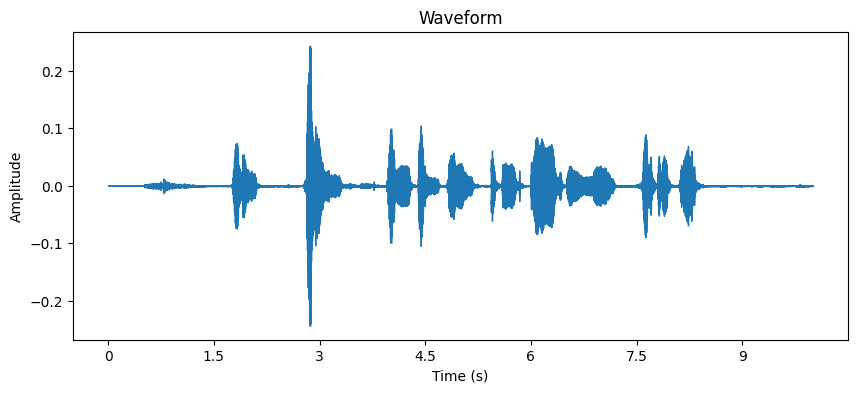

Sample Rate: 16000
Utterance: hello how are you I am fine I think we can have a great chat
Speaker ID: speaker_001
Chapter ID: 6463b6dd
Utterance ID: 31c843ca
Features saved to audio_features.json!

Feature extraction complete!


TypeError: Unknown type passed as data object: <class 'dict'>

In [42]:
import sounddevice as sd
import numpy as np
import wave
import uuid
import librosa
import librosa.display
import matplotlib.pyplot as plt
import speech_recognition as sr
import json
import shap

def record_audio(duration=5, sample_rate=16000, filename="recorded_audio.wav"):
    """
    Records audio in real-time and saves it as a WAV file.
    """
    print("Recording... Speak now!")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording finished.")

    # Save audio data as a WAV file
    audio_data = (audio_data * 32767).astype(np.int16)  # Convert to int16 for WAV format
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # Mono channel
        wf.setsampwidth(2)  # 2 bytes per sample
        wf.setframerate(sample_rate)
        wf.writeframes(audio_data.tobytes())
    return filename

def extract_features(audio_file):
    """
    Extracts features from the recorded audio file.
    """
    # Load audio file
    waveform, sample_rate = librosa.load(audio_file, sr=None)

    # Plot waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Extract speech content (utterance)
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_file) as source:
            audio = recognizer.record(source)
        utterance = recognizer.recognize_google(audio)
    except sr.UnknownValueError:
        utterance = "Speech not recognized."
    except sr.RequestError as e:
        utterance = f"Speech-to-text API error: {e}"

    # Generate unique IDs
    speaker_id = "speaker_001"  # Static ID (can be dynamic in future)
    chapter_id = str(uuid.uuid4())[:8]  # Random unique chapter ID
    utterance_id = str(uuid.uuid4())[:8]  # Random unique utterance ID

    # Print features
    print(f"Sample Rate: {sample_rate}")
    print(f"Utterance: {utterance}")
    print(f"Speaker ID: {speaker_id}")
    print(f"Chapter ID: {chapter_id}")
    print(f"Utterance ID: {utterance_id}")

    # Save features as JSON
    features = {
        "waveform": waveform.tolist(),
        "sample_rate": sample_rate,
        "utterance": utterance,
        "speaker_id": speaker_id,
        "chapter_id": chapter_id,
        "utterance_id": utterance_id,
    }
    with open("audio_features.json", "w") as f:
        json.dump(features, f, indent=4)
    print("Features saved to audio_features.json!")

    return features

# Main program
if __name__ == "__main__":
    duration = int(input("Enter recording duration (in seconds): "))
    filename = record_audio(duration=duration)

    print("\nExtracting features...")
    features = extract_features(filename)
    print("\nFeature extraction complete!")

    explainer = shap.KernelExplainer(rf.predict, features)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


In [38]:
explainer = shap.KernelExplainer(rf.predict, features)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


Provided model function fails when applied to the provided data set.


ValueError: X has 2620 features, but RandomForestClassifier is expecting 33 features as input.

### Build the Emotion Recognition Model

Features and labels saved to 'features_with_labels.csv'

--- Classification Report for RF ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.25      0.25         4
           2       0.00      0.00      0.00         3
           3       0.42      0.71      0.53         7
           5       0.00      0.00      0.00         3

    accuracy                           0.30        20
   macro avg       0.13      0.19      0.16        20
weighted avg       0.20      0.30      0.23        20

Confusion Matrix:
 [[0 0 1 2 0]
 [0 1 2 1 0]
 [0 1 0 2 0]
 [1 1 0 5 0]
 [0 1 0 2 0]]


C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


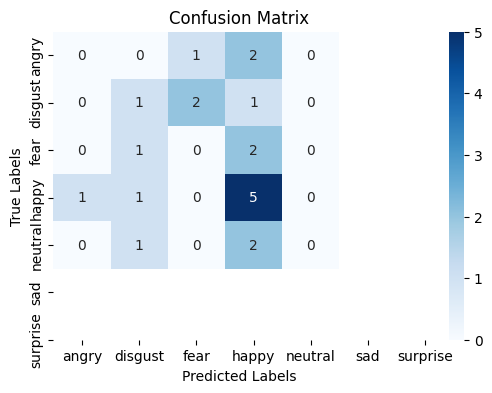


--- Classification Report for SVM ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.17      0.25      0.20         4
           2       0.50      0.67      0.57         3
           3       0.25      0.14      0.18         7
           5       0.00      0.00      0.00         3

    accuracy                           0.20        20
   macro avg       0.18      0.21      0.19        20
weighted avg       0.20      0.20      0.19        20

Confusion Matrix:
 [[0 2 0 1 0]
 [2 1 0 1 0]
 [0 1 2 0 0]
 [1 2 1 1 2]
 [1 0 1 1 0]]


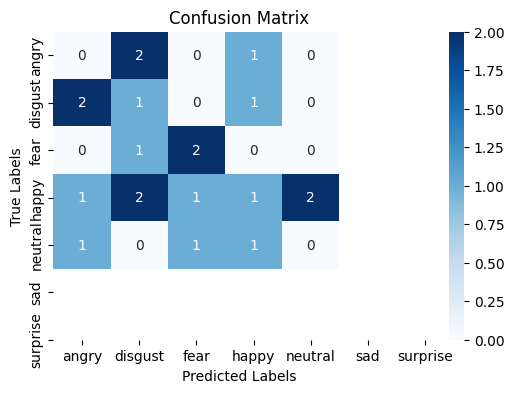


--- Classification Report for DT ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.40      0.29      0.33         7
           4       0.00      0.00      0.00         0
           5       0.50      0.33      0.40         3

    accuracy                           0.15        20
   macro avg       0.15      0.10      0.12        20
weighted avg       0.22      0.15      0.18        20

Confusion Matrix:
 [[0 1 1 0 0 1]
 [1 0 2 1 0 0]
 [0 1 0 1 1 0]
 [0 2 2 2 1 0]
 [0 0 0 0 0 0]
 [0 1 0 1 0 1]]


C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


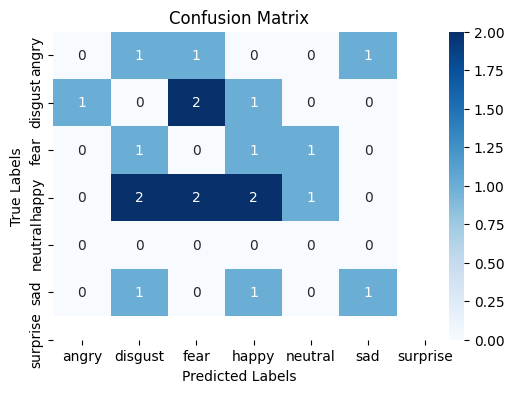

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Define emotion labels
emotion_mapping = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

# Function to assign rule-based labels
def assign_rule_based_label(features):
    pitch = features[0]  # Example: First MFCC as proxy for pitch
    loudness = features[1]  # Example: Second MFCC as proxy for loudness

    if pitch > 20 and loudness > 10:
        return 3  # Happy
    elif pitch < 10 and loudness < 5:
        return 5  # Sad
    elif pitch > 25 and loudness < 8:
        return 0  # Angry
    elif pitch < 5 and loudness > 15:
        return 2  # Fear
    else:
        return 4  # Neutral

# Function to process and assign combined labels
def assign_labels(features_array, metadata=None):
    labels = []
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_array)  # Normalize features for clustering

    # Step 1: Clustering-Based Labels
    num_clusters = len(emotion_mapping)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)

    for i, feature in enumerate(features_array):
        # Step 2: Use metadata for initial label assignment if available
        if metadata is not None and len(metadata) > 0:
            speaker_id = metadata[i]  # Example: Use speaker_id or other metadata
            label = speaker_id % num_clusters  # Assign based on speaker_id
        else:
            label = cluster_labels[i]  # Use clustering label as default

        # Step 3: Refine labels using rule-based logic
        rule_based_label = assign_rule_based_label(feature)
        if label == 4:  # Neutral cluster refinement example
            label = rule_based_label

        labels.append(label)

    return labels

# Function to train and evaluate a model
def train_and_evaluate_model(X, y, model_type='rf'):
    """
    Train and evaluate a classifier.
    Args:
        X: Features.
        y: Labels.
        model_type: 'rf' for Random Forest, 'svm' for SVM, 'dt' for Decision Tree.
    """
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model based on the type
    if model_type == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'svm':
        model = SVC(kernel='linear', random_state=42)
    elif model_type == 'dt':
        model = DecisionTreeClassifier(random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print(f"\n--- Classification Report for {model_type.upper()} ---")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)


    # Plotting the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example workflow
# Simulate features array and metadata
np.random.seed(42)
features_array = np.random.rand(100, 13) * 50  # Simulated features (100 samples, 13 features)
metadata = np.random.randint(0, 6, size=100)  # Simulated metadata (e.g., speaker IDs)

# Assign combined labels
combined_labels = assign_labels(features_array, metadata)

# Map numeric labels to emotion categories
emotion_labels = [emotion_mapping[label] for label in combined_labels]

# Save features with labels to a DataFrame
features_df = pd.DataFrame(features_array, columns=[f'Feature_{i+1}' for i in range(features_array.shape[1])])
features_df['Label'] = combined_labels
features_df['Emotion'] = emotion_labels

# Save to CSV
features_df.to_csv("features_with_labels.csv", index=False)
print("Features and labels saved to 'features_with_labels.csv'")

X = features_array 
y = combined_labels

# Train and evaluate models for each type
train_and_evaluate_model(X, y, model_type='rf')  # Random Forest
train_and_evaluate_model(X, y, model_type='svm')  # SVM
train_and_evaluate_model(X, y, model_type='dt')  # Decision Tree


C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         3
           4       0.17      1.00      0.29         1
           5       1.00      0.43      0.60         7
           6       0.75      1.00      0.86         3

    accuracy                           0.55        20
   macro avg       0.50      0.63      0.49        20
weighted avg       0.63      0.55      0.53        20

Confusion Matrix:
 [[3 0 0 0 0 0]
 [0 1 0 2 0 0]
 [0 1 0 1 0 1]
 [0 0 0 1 0 0]
 [1 1 0 2 3 0]
 [0 0 0 0 0 3]]


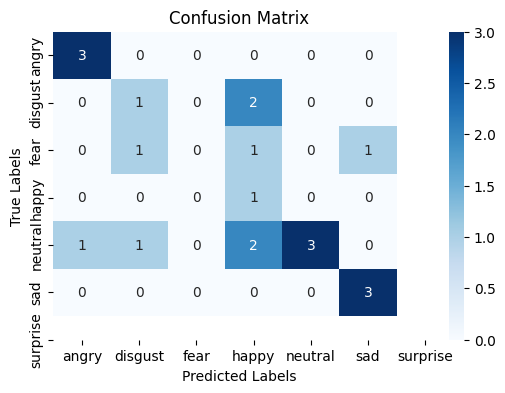

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

X = features_array  # Extracted features

# Generate dummy target labels
'''
neutral = 1 
sad = 2
happy = 3
'''

# Use K-Means to cluster features into 3 groups (neutral, sad, happy)
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_array)

# Use cluster labels as your target labels
y = cluster_labels

# # Ensure the number of labels matches the number of rows in the features array
# num_samples = features_array.shape[0]
# y = np.random.choice(labels, num_samples)  # Randomly assign one label to each sample

# Assume `X` contains features and `y` contains emotion labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Convert X_train and X_test to float32
X_train = X_train.astype(np.float32).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.astype(np.float32).reshape(X_test.shape[0], X_test.shape[1], 1)

# Re-train the model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.2055 - loss: 9.5805 - val_accuracy: 0.2000 - val_loss: 4.6952
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2523 - loss: 5.9277 - val_accuracy: 0.1000 - val_loss: 5.7985
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2211 - loss: 5.1569 - val_accuracy: 0.1000 - val_loss: 4.9189
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1719 - loss: 5.2390 - val_accuracy: 0.1500 - val_loss: 4.0684
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2609 - loss: 4.3151 - val_accuracy: 0.1500 - val_loss: 4.0858
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3414 - loss: 3.0829 - val_accuracy: 0.1500 - val_loss: 3.8547
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2641 - loss: 3.3318 - val_accuracy: 0.1500 - val_loss: 3.4832
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2742 - loss: 3.3335 - val_accuracy: 0.1500 - val_loss: 2.873

Accuracy: 0.55


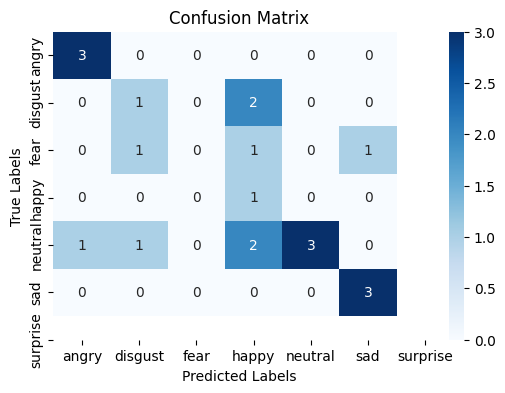

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torchaudio

# Load a sample audio file from LibriSpeech
datasets = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

key = 0
for dataset in datasets:  
    if ( key < 10):
        # Access the first audio sample in the dataset
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset

         # Extract features directly from waveform
        new_features = extract_features_from_waveform(waveform, sample_rate)
        new_features = new_features.reshape(1, -1)  # Reshape for prediction
        key += 1
        
        # Predict emotion
        predicted_emotion = rf_model.predict(new_features)
        print("WaveForm Predicted Emotion:", predicted_emotion)

In [8]:
import librosa
import numpy as np
import pandas as pd
import torchaudio
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForCTC

# Load the pre-trained model and feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")
model = Wav2Vec2ForCTC.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")

#Print available labels for debugging
print("Available labels:", model.config.id2label)
    

# Define a function to predict emotion from audio
def predict_emotion(audio_path):
    # Load the audio file
    audio, rate = librosa.load(audio_path, sr=16000)
    
    # Extract features
    inputs = feature_extractor(audio, sampling_rate=rate, return_tensors="pt", padding=True)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(inputs.input_values)

    # Process predictions
    predictions = torch.nn.functional.softmax(outputs.logits.mean(dim=1), dim=-1)  # Average over sequence length
    predicted_label = torch.argmax(predictions, dim=-1)

    # Check if predicted label exists in id2label mapping
    try:
        emotion = model.config.id2label[predicted_label.item()]
    except KeyError:
        print(f"KeyError: Predicted label {predicted_label.item()} not found in id2label.")
        return None
    
    return emotion


Some weights of the model checkpoint at r-f/wav2vec-english-speech-emotion-recognition were not used when initializing Wav2Vec2ForCTC: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at r-f/wav2vec-english-speech-emotion-recognition and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

Available labels: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\komal\anaconda3\envs\stt-erp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       1.00      0.33      0.50         3
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       1.00      0.71      0.83         7
           6       0.60      1.00      0.75         3

    accuracy                           0.65        20
   macro avg       0.59      0.48      0.46        20
weighted avg       0.82      0.65      0.65        20

Accuracy: 0.65


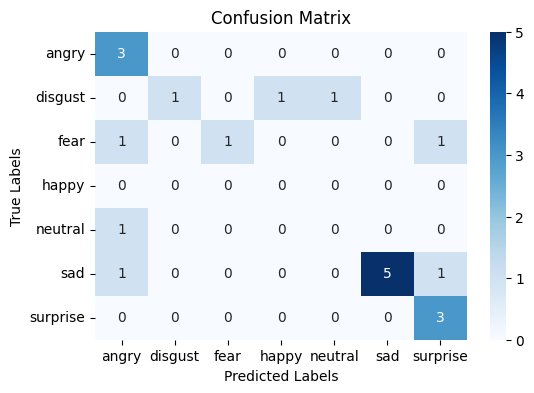

In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import numpy as np

# Assuming `features` is a 2D array of extracted features and `labels` is an array of corresponding labels
X = np.array(features_array)  # Feature matrix

# Use K-Means to cluster features into 3 groups (neutral, sad, happy)
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_array)

# Use cluster labels as your target labels
y = cluster_labels

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
classifier = svm.SVC(kernel='linear')  # You can experiment with different kernels
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", cm)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Load a sample audio file from LibriSpeech
datasets = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)


file_path = "librispeech_sample.wav"
key = 0
# Loop through the dataset and process the first 10 samples
for dataset in datasets:  
     if ( key < 10):
        # Access the first audio sample in the dataset
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset
        
        # Save the audio to a WAV file
        torchaudio.save(file_path, waveform, sample_rate)
        
        # Predict emotion for the saved audio file
        emotion = predict_emotion(file_path)
        key += 1
        if emotion is not None:
            print(f"Predicted emotion for sample {key}: {emotion}")

Predicted emotion for sample 1: happy
Predicted emotion for sample 2: happy
Predicted emotion for sample 3: happy
KeyError: Predicted label 16 not found in id2label.
KeyError: Predicted label 7 not found in id2label.
Predicted emotion for sample 6: happy
Predicted emotion for sample 7: happy
Predicted emotion for sample 8: happy
KeyError: Predicted label 21 not found in id2label.
Predicted emotion for sample 10: happy


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.65
Confusion Matrix:
 [[3 0 0 0 0 0 0]
 [0 1 0 1 1 0 0]
 [1 0 1 0 0 0 1]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 5 1]
 [0 0 0 0 0 0 3]]


@TODO so what my next step will be what ever the model predict i will assign to a category which will near to the any category that way i can classifiy any model 

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import librosa
import torchaudio

# Load the pre-trained speech embedding model
model_url = "https://tfhub.dev/google/speech_embedding/1"
model = hub.load(model_url)

# Define a function to extract embeddings
def extract_embeddings(audio_path, max_length=123):
    # Load the audio file
    audio, rate = librosa.load(audio_path, sr=16000)
    
    # Ensure the input has the correct shape (batch size, time)
    audio_tensor = tf.constant(audio[np.newaxis, :], dtype=tf.float32)

    # Use the model's default signature to extract embeddings
    if "default" in model.signatures:
        embeddings = model.signatures["default"](audio_tensor)["default"]
    else:
        raise ValueError("The model does not have a callable default signature.")
    
    # Convert embeddings to numpy array and reshape
    embeddings = embeddings.numpy().squeeze()  # Remove batch and channel dimensions
    if len(embeddings.shape) == 3:  # If shape is (123, 1, 96), remove extra dimension
        embeddings = embeddings[:, 0, :]
    
    # Pad or truncate embeddings to ensure uniform shape
    if embeddings.shape[0] < max_length:
        padding = np.zeros((max_length - embeddings.shape[0], embeddings.shape[1]))
        embeddings = np.vstack([embeddings, padding])  # Pad
    elif embeddings.shape[0] > max_length:
        embeddings = embeddings[:max_length, :]  # Truncate
    
    return embeddings


# Load a sample audio dataset from LibriSpeech
datasets = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

# File path for temporary storage
file_path = "librispeech_sample.wav"

features = []  # List to store extracted features
key = 0  # Counter for processed samples
max_length = 123  # Maximum length for embeddings (adjust based on your data)

# Loop through the dataset and process the first 10 samples
for dataset in datasets:
    # if key < 10:
    # Access the first audio sample in the dataset
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset

    # Save the audio to a WAV file for processing
    torchaudio.save(file_path, waveform, sample_rate)

    # Extract embeddings using the pre-trained model
    embeddings = extract_embeddings(file_path, max_length=max_length)
    features.append(embeddings)  # Store the embeddings

    #     key += 1
    # else:
    #     break

# Convert the features list to a 3D NumPy array
features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")


Extracted features shape: (2620, 123, 96)


Label distribution: {np.int64(0): np.int64(374), np.int64(1): np.int64(374), np.int64(2): np.int64(375), np.int64(3): np.int64(374), np.int64(4): np.int64(375), np.int64(5): np.int64(374), np.int64(6): np.int64(374)}
              precision    recall  f1-score   support

           0       0.17      0.18      0.18        76
           1       0.08      0.10      0.09        70
           2       0.16      0.17      0.16        82
           3       0.17      0.14      0.15        85
           4       0.10      0.09      0.09        80
           5       0.12      0.14      0.13        65
           6       0.09      0.08      0.08        66

    accuracy                           0.13       524
   macro avg       0.13      0.13      0.13       524
weighted avg       0.13      0.13      0.13       524



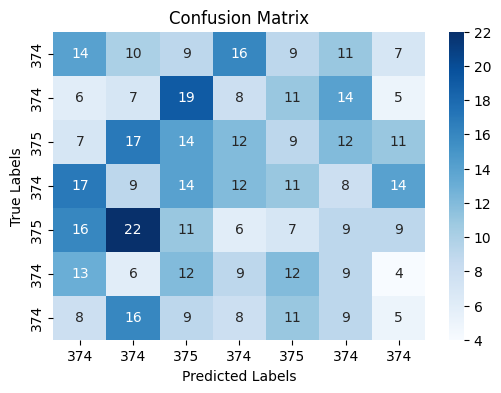

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

# Convert features to a NumPy array
features_array = np.array(features)

# Flatten features to 2D: (samples, features)
flattened_features = features_array.reshape(features_array.shape[0], -1)

# Generate balanced labels ensuring at least 2 samples per class
num_samples = flattened_features.shape[0]  # Ensure the number of labels matches the number of samples
num_classes = 7

# Create balanced labels only if possible
if num_samples >= num_classes * 2:  # Ensure we have at least 2 samples per class
    samples_per_class = num_samples // num_classes
    remainder = num_samples % num_classes

    # Create balanced labels
    balanced_labels = np.repeat(np.arange(num_classes), samples_per_class)
    if remainder > 0:
        extra_labels = np.random.choice(np.arange(num_classes), size=remainder, replace=False)
        balanced_labels = np.hstack([balanced_labels, extra_labels])

    # Shuffle the labels
    labels = shuffle(balanced_labels)

    # Ensure the labels array has the same length as the features array
    labels = labels[:num_samples]

    # Check distribution of labels
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print("Label distribution:", label_distribution)

    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(flattened_features, labels, test_size=0.2, random_state=42)

    # Train an SVM classifier
    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate performance
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # print("Confusion Matrix:\n", cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_distribution.values(), yticklabels=label_distribution.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Not enough samples to create balanced classes.")
